批处理ESD表格，主要把时间戳转化为时间轴

In [ ]:
import os
import pandas as pd

dirlist = os.listdir('../CollectedData/BINS/')
print(dirlist)
for i in dirlist:
    data = pd.read_csv('../CollectedData/BINS/'+i)
    time_df = data.iloc[:,0] # 获取时间戳的那一列
    bins_df = data.iloc[:,1:-1] # 获取bins的列
    data['max'] = bins_df.max(axis=1) # 找到bins中每一行的最大值，并且赋值给max列
    data['time'] = (time_df-time_df[0])/1000
    output = data[['time','max']]
    output.to_csv('../CollectedData/OutBINS/out_'+i, index=False)

超声波信号和音频信号相乘

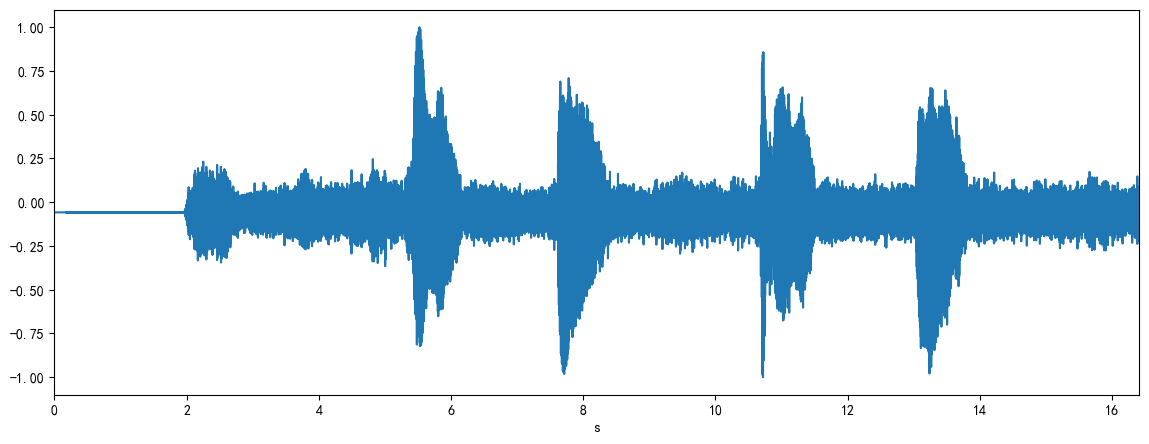

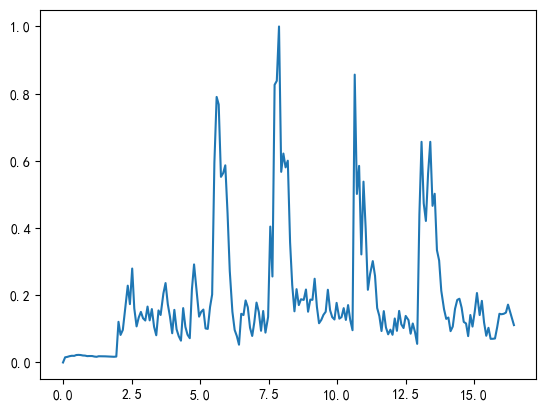

In [5]:
import utils.speechlib
from utils.soundBase import soundBase
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import librosa

sb = soundBase('../CollectedData/WAV/SingleWav1.wav') # 读取音频文件
audio_data , fs = sb.audioread()

esd_df = pd.read_csv('../CollectedData/OutBINS/out_TEST_BINS1.csv') # 读取ESD数据文件
esd_time = esd_df['time']
esd_data = esd_df['max']

# 音频幅值归一化
min_max_scaler1 = MinMaxScaler(feature_range=(-1,1),copy=True) # 定义归一化的范围为[-1,1]
audio_data_minmax = min_max_scaler1.fit_transform(audio_data.reshape(-1,1))
sb.soundplot(audio_data_minmax,sr=fs)

# 超声波幅值归一化
min_max_scaler2 = MinMaxScaler(feature_range=(0,1),copy=True) # 定义归一化的范围为[0,1]
esd_data_minmax = min_max_scaler2.fit_transform(esd_data.values.reshape(-1,1))
plt.plot(esd_time.values,esd_data_minmax)

# 音频下采样
audio_data_minmax_downsampled = librosa.resample(y=audio_data_minmax.reshape(1,-1),orig_sr = fs, target_sr= 16000) # 下采样至16Khz

# 超声波上采样
